In [2]:
import numpy # pandas library requires newer version of numpy, so to add it in requirements.txt
import pandas as pd

weather = pd.read_csv("data/weather.csv", index_col="DATE")

<AxesSubplot:xlabel='DATE'>

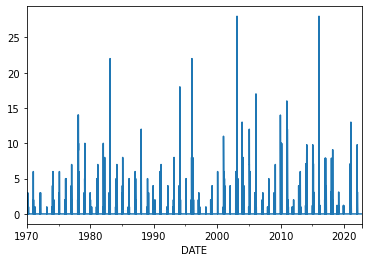

In [3]:
null_pct = weather.apply(pd.isnull).sum()/weather.shape[0]
valid_columns = weather.columns[null_pct < .05]
weather = weather[valid_columns].copy()
weather.columns = weather.columns.str.lower()
weather = weather.ffill()
weather.apply(pd.isnull).sum()
weather.apply(lambda x: (x == 9999).sum())
weather.index = pd.to_datetime(weather.index)
weather.index.year.value_counts().sort_index()
weather["snwd"].plot()

In [4]:
weather["target"] = weather.shift(-1)["tmax"]
weather = weather.ffill()
weather["target"]

DATE
1970-01-01    31.0
1970-01-02    38.0
1970-01-03    31.0
1970-01-04    35.0
1970-01-05    36.0
              ... 
2022-10-17    58.0
2022-10-18    56.0
2022-10-19    61.0
2022-10-20    64.0
2022-10-21    64.0
Name: target, Length: 19287, dtype: float64

In [5]:
from sklearn.linear_model import Ridge

rr = Ridge(alpha=.1)

predictors = weather.columns[~weather.columns.isin(["target", "name", "station"])]

def backtest(weather, model, predictors, start=3650, step=90):
    all_predictions = []
    
    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i,:]
        test = weather.iloc[i:(i+step),:]

        model.fit(train[predictors], train["target"])
        
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)


predictions = backtest(weather, rr, predictors)
predictions

,actual,prediction,diff
DATE,,,
1979-12-30,43.0,50.229324,7.229324
1979-12-31,42.0,43.673798,1.673798
1980-01-01,41.0,41.579150,0.579150
1980-01-02,36.0,43.961887,7.961887
1980-01-03,30.0,40.204726,10.204726
...,...,...,...
2022-10-17,58.0,67.543412,9.543412
2022-10-18,56.0,60.511771,4.511771
2022-10-19,61.0,57.030435,3.969565


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_absolute_error(predictions["actual"], predictions["prediction"])

predictions.sort_values("diff", ascending=False)
pd.Series(rr.coef_, index=predictors)

prcp   -1.236110
snow   -0.407827
snwd    0.053422
tmax    0.447413
tmin    0.517302
dtype: float64

In [7]:
def pct_diff(old, new):
    return (new - old) / old

def compute_rolling(weather, horizon, col):
    label = f"rolling_{horizon}_{col}"
    weather[label] = weather[col].rolling(horizon).mean()
    weather[f"{label}_pct"] = pct_diff(weather[label], weather[col])
    return weather
    
rolling_horizons = [3, 14]
for horizon in rolling_horizons:
    for col in ["tmax", "tmin", "prcp"]:
        weather = compute_rolling(weather, horizon, col)

def expand_mean(df):
    return df.expanding(1).mean()

for col in ["tmax", "tmin", "prcp"]:
    weather[f"month_avg_{col}"] = weather[col].groupby(weather.index.month, group_keys=False).apply(expand_mean)
    weather[f"day_avg_{col}"] = weather[col].groupby(weather.index.day_of_year, group_keys=False).apply(expand_mean)

<AxesSubplot:>

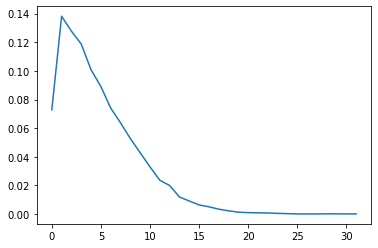

In [8]:
weather = weather.iloc[14:,:]
weather = weather.fillna(0)
predictors = weather.columns[~weather.columns.isin(["target", "name", "station"])]
predictions = backtest(weather, rr, predictors)
mean_absolute_error(predictions["actual"], predictions["prediction"])
mean_squared_error(predictions["actual"], predictions["prediction"])
predictions.sort_values("diff", ascending=False)
weather.loc["1990-03-07": "1990-03-17"]
(predictions["diff"].round().value_counts().sort_index() / predictions.shape[0]).plot()

<AxesSubplot:xlabel='DATE'>

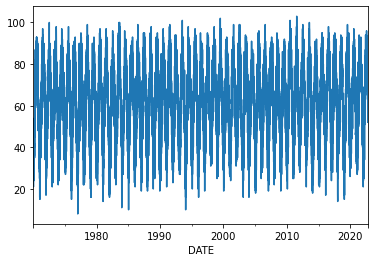

In [9]:
weather["target"].plot()

In [10]:
mean_squared_error(predictions["actual"], predictions["prediction"], squared=False)

6.128586225318433

In [11]:
predictions

,actual,prediction,diff
DATE,,,
1980-01-13,54.0,32.456685,21.543315
1980-01-14,51.0,44.691816,6.308184
1980-01-15,45.0,46.860712,1.860712
1980-01-16,40.0,42.201133,2.201133
1980-01-17,41.0,40.841305,0.158695
...,...,...,...
2022-10-17,58.0,67.010448,9.010448
2022-10-18,56.0,62.415946,6.415946
2022-10-19,61.0,59.725121,1.274879


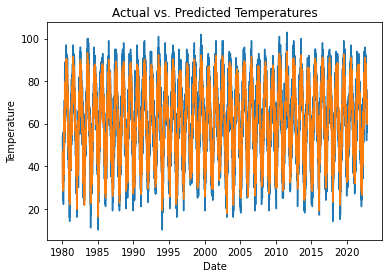

In [12]:
# show the graph of the predictions with the actuals
import matplotlib.pyplot as plt
plt.plot(predictions["actual"])
plt.plot(predictions["prediction"])
# stretch this graph to make it larger
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Actual vs. Predicted Temperatures")
plt.show()


            actual  prediction       diff
DATE                                     
1980-01-13    54.0   32.456685  21.543315
1980-01-14    51.0   44.691816   6.308184
1980-01-15    45.0   46.860712   1.860712
1980-01-16    40.0   42.201133   2.201133
1980-01-17    41.0   40.841305   0.158695
...            ...         ...        ...
2022-10-17    58.0   67.010448   9.010448
2022-10-18    56.0   62.415946   6.415946
2022-10-19    61.0   59.725121   1.274879
2022-10-20    64.0   62.351762   1.648238
2022-10-21    64.0   63.334734   0.665266

[15623 rows x 3 columns]


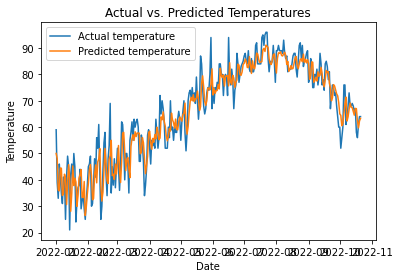

In [20]:
plt.plot(predictions["actual"]["2022"], label="Actual temperature")
plt.plot(predictions["prediction"]["2022"], label="Predicted temperature")
print(predictions)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Actual vs. Predicted Temperatures")
plt.legend()
plt.show()

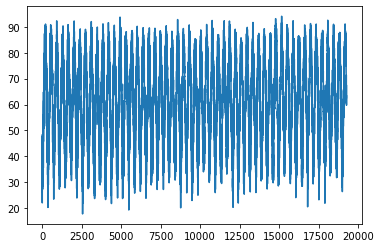

In [27]:
new_pred = rr.predict(weather[predictors])
plt.plot(new_pred)
new_pred = pd.Series(new_pred, index=weather[predictors].index)
# plt.plot(predictions["prediction"])
plt.show()

                    0
2025-01-01  26.118190
2025-01-02  34.003049
2025-01-03  40.367683
2025-01-04  36.381869
2025-01-05  25.261883
...               ...
2074-12-28  53.774122
2074-12-29  53.759882
2074-12-30  45.070867
2074-12-31  44.922162
2075-01-01  48.990526

[18263 rows x 1 columns]


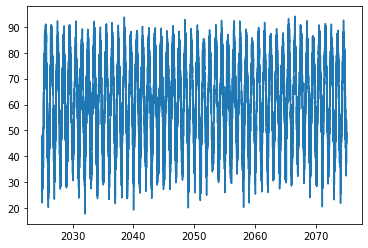

In [28]:

start_date = '2025-01-01'
end_date = '2075-01-01'
dates = pd.date_range(start=start_date, end=end_date)
new_pred_df = pd.DataFrame(new_pred)
new_pred_df = new_pred_df[:len(dates)]
new_pred_df.index = dates

plt.plot(new_pred_df)
print(new_pred_df)



c:\Users\ACER\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


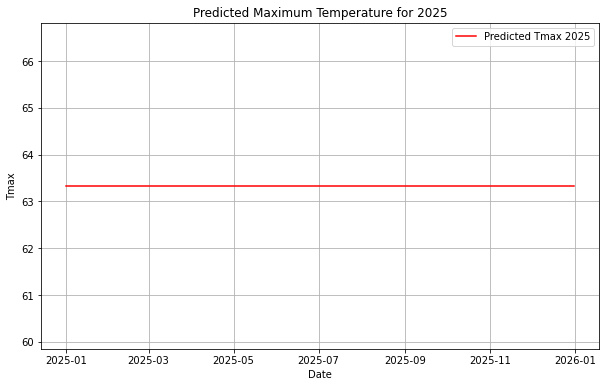

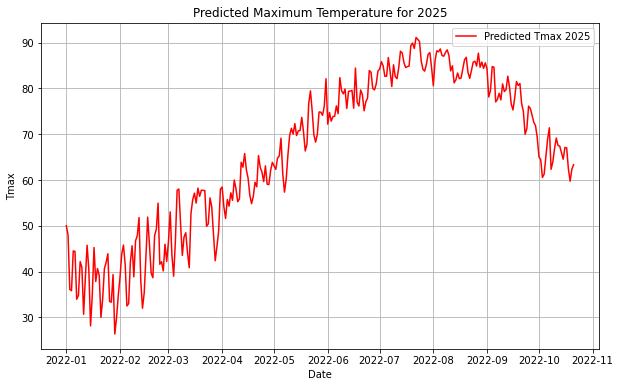

In [35]:
weather_2025 = pd.DataFrame(index=pd.date_range(start='2025-01-01', end='2025-12-31'))
weather_2025[predictors] = weather.iloc[-1][predictors].values  # Reshape the values for prediction
predictions_2025 = rr.predict(weather_2025[predictors].values.reshape(-1, len(predictors)))  # Reshape the values for prediction

# Plot the temperature graph for 2025
plt.figure(figsize=(10, 6))
plt.plot(weather_2025.index, predictions_2025, label='Predicted Tmax 2025', color='red')
plt.xlabel('Date')
plt.ylabel('Tmax')
plt.title('Predicted Maximum Temperature for 2025')
plt.legend()
plt.grid(True)
plt.show()

X=weather[predictors]
X_2023 = X[X.index.year == 2022]  # Assuming you have data up to 2024
predictions_2023 = rr.predict(X_2023)

# Plot the temperature graph for 2025
plt.figure(figsize=(10, 6))
plt.plot(X_2023.index, predictions_2023, label='Predicted Tmax 2025', color='red')
plt.xlabel('Date')
plt.ylabel('Tmax')
plt.title('Predicted Maximum Temperature for 2025')
plt.legend()
plt.grid(True)
plt.show()